In [1]:
from qiskit import QuantumCircuit
from qiskit_nature.drivers import Molecule

import numpy as np
import matplotlib.pyplot as plt
import os.path
import json
import importlib
import signal

from src.utils import *
from src.benchmarks import (
    qft,
    shor,
    hhl,
)
from src.benchmarks.qiskit_application_optimization import routing, tsp
from src.benchmarks.qiskit_application_finance import (
    pricingcall,
    pricingput,
)
from src.benchmarks.qiskit_application_nature import groundstate, excitedstate

# New Structure of Generator

In [2]:
def create_benchmarks_from_config(cfg=None):
    characteristics = []

    if not cfg:
        with open("config.json", "r") as jsonfile:
            cfg = json.load(jsonfile)
            print("Read config successful")

    # global seetings
    global save_png
    save_png = cfg["save_png"]
    global save_hist
    save_hist = cfg["save_hist"]
    global max_depth
    max_depth = cfg["max_depth"]
    global timeout
    timeout = cfg["timeout"]

    for benchmark in cfg["benchmarks"]:
        print(benchmark["name"])  #
        characteristics.extend(generate_benchmark(benchmark))
    return characteristics

In [3]:
def benchmark_generation_watcher(func, args):
    class TimeoutException(Exception):  # Custom exception class
        pass

    def timeout_handler(signum, frame):  # Custom signal handler
        raise TimeoutException

    # Change the behavior of SIGALRM
    signal.signal(signal.SIGALRM, timeout_handler)

    signal.alarm(timeout)
    try:
        filename, depth, num_qubits = func(*args)
    except:
        print("Calculation/Generation exceeded timeout limit for ", func, args[1:])

        if func == get_indep_layer:
            qc = args[0]
            num_qubits = args[1]
            filename_indep = qc.name + "_t-indep_" + str(num_qubits)
            path = "qasm_output/" + filename_indep + ".qasm"

            if os.path.isfile(path):
                os.remove(path)
                print("removed file: ", path)

        elif func == get_native_gates_layer:
            qc = args[0]
            gate_set_name = args[2]
            opt_level = args[3]
            num_qubits = args[4]

            filename_nativegates = (
                qc.name
                + "_nativegates_"
                + gate_set_name
                + "_opt"
                + str(opt_level)
                + "_"
                + str(num_qubits)
            )

            path = "qasm_output/" + filename_nativegates + ".qasm"
            if os.path.isfile(path):
                os.remove(path)
                print("removed file: ", path)

        elif func == get_mapped_layer:
            qc = args[0]
            gate_set_name_mapped = args[2]
            opt_level = args[3]
            num_qubits = args[4]

            filename_mapped = (
                qc.name
                + "_mapped_"
                + gate_set_name_mapped
                + "_opt"
                + str(opt_level)
                + "_"
                + str(num_qubits)
            )

            path = "qasm_output/" + filename_mapped + ".qasm"
            if os.path.isfile(path):
                os.remove(path)
                print("removed file: ", path)

        return False
    else:
        # Reset the alarm
        signal.alarm(0)

    if depth > max_depth:
        print("Depth of generated circuit is too large: ", depth)
        return False

    return filename, depth, num_qubits

In [4]:
def qc_creation_watcher(func, args):
    class TimeoutException(Exception):  # Custom exception class
        pass

    def timeout_handler(signum, frame):  # Custom signal handler
        raise TimeoutException

    # Change the behavior of SIGALRM
    signal.signal(signal.SIGALRM, timeout_handler)

    signal.alarm(timeout)
    try:
        qc, num_qubits, file_precheck = func(*args)
    except TimeoutException:
        print("Calculation/Generation exceeded timeout limit for ", func, args[1:])
        return False
    except Exception as e:
        print("Something else went wrong: ", e)
        return False
    else:
        # Reset the alarm
        signal.alarm(0)

    return qc, num_qubits, file_precheck

In [5]:
def generate_benchmark(benchmark):
    characteristics = []
    if benchmark["include"]:
        if benchmark["name"] == "grover" or benchmark["name"] == "qwalk":
            for anc_mode in benchmark["ancillary_mode"]:
                for n in range(
                    benchmark["min_qubits"],
                    benchmark["max_qubits"],
                    benchmark["stepsize"],
                ):
                    res_qc_creation = qc_creation_watcher(
                        create_scalable_qc, [benchmark, n, anc_mode]
                    )
                    if not res_qc_creation:
                        break
                    res = generate_circuits_on_all_layer(*res_qc_creation)
                    if len(res) == 0:
                        break
                    characteristics.extend(res)

        elif benchmark["name"] == "shor":
            for choice in benchmark["instances"]:
                res_qc_creation = qc_creation_watcher(create_shor_qc, [choice])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["name"] == "hhl":
            for i in range(benchmark["min_index"], benchmark["max_index"]):
                res_qc_creation = qc_creation_watcher(create_hhl_qc, [i])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)
                break

        elif benchmark["name"] == "routing":
            for nodes in range(benchmark["min_nodes"], benchmark["max_nodes"]):
                res_qc_creation = qc_creation_watcher(create_routing_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["name"] == "tsp":
            for nodes in range(benchmark["min_nodes"], benchmark["max_nodes"]):
                res_qc_creation = qc_creation_watcher(create_tsp_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["name"] == "groundstate":
            for choice in benchmark["instances"]:
                res_qc_creation = qc_creation_watcher(create_groundstate_qc, [choice])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["name"] == "excitedstate":
            for choice in benchmark["instances"]:
                res_qc_creation = qc_creation_watcher(create_excitedstate_qc, [choice])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["name"] == "pricingcall":
            for nodes in range(
                benchmark["min_uncertainty"], benchmark["max_uncertainty"]
            ):
                res_qc_creation = qc_creation_watcher(create_pricingcall_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["name"] == "pricingput":
            for nodes in range(
                benchmark["min_uncertainty"], benchmark["max_uncertainty"]
            ):
                res_qc_creation = qc_creation_watcher(create_pricingput_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)
        else:
            for n in range(
                benchmark["min_qubits"], benchmark["max_qubits"], benchmark["stepsize"]
            ):

                # res_qc_creation == qc, num_qubits, file_precheck
                # res == filename, depth, num_qubits
                res_qc_creation = qc_creation_watcher(
                    create_scalable_qc, [benchmark, n]
                )
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

    return characteristics

In [6]:
def generate_circuits_on_all_layer(qc, num_qubits, file_precheck):
    characteristics = []
    # filename_algo, depth = generate_algo_layer_circuit(qc, n, save_png, save_hist)
    # characteristics.append([filename_algo, n, depth])

    res_t_indep = generate_target_indep_layer_circuit(
        qc, num_qubits, save_png, save_hist, file_precheck
    )

    if res_t_indep:
        characteristics.extend(res_t_indep)
    else:
        return characteristics

    res_t_dep = generate_target_dep_layer_circuit(
        qc, num_qubits, save_png, save_hist, file_precheck
    )

    if res_t_dep:
        characteristics.extend(res_t_dep)
    else:
        return characteristics

    return characteristics

In [7]:
def generate_algo_layer_circuit(
    qc: QuantumCircuit, num_qubits: int, save_png, save_hist
):
    characteristics = []
    res = benchmark_generation_watcher(
        handle_algorithm_layer, [qc, num_qubits, save_png, save_hist]
    )
    characteristics.append(res)

    if res:
        characteristics.append(res)
        return characteristics
    else:
        return False

In [8]:
def generate_target_indep_layer_circuit(
    qc: QuantumCircuit, num_qubits: int, save_png, save_hist, file_precheck
):
    characteristics = []
    res = benchmark_generation_watcher(
        get_indep_layer, [qc, num_qubits, save_png, save_hist, file_precheck]
    )
    if res:
        characteristics.append(res)
        return characteristics
    else:
        return False

In [9]:
def generate_target_dep_layer_circuit(
    qc: QuantumCircuit, num_qubits: int, save_png, save_hist, file_precheck
):
    characteristics = []

    ibm_native_gates = FakeMontreal().configuration().basis_gates
    rigetti_native_gates = ["rx", "rz", "cz"]
    gate_sets = [(ibm_native_gates, "ibm"), (rigetti_native_gates, "rigetti")]

    for gate_set, gate_set_name in gate_sets:
        try:
            for opt_level in range(4):

                # Creating the circuit on target-dependent: native gates layer

                res = benchmark_generation_watcher(
                    get_native_gates_layer,
                    [
                        qc,
                        gate_set,
                        gate_set_name,
                        opt_level,
                        num_qubits,
                        save_png,
                        save_hist,
                        file_precheck,
                    ],
                )
                if res:
                    characteristics.append(res)
                else:
                    break
                n_actual = res[2]

                # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                res = benchmark_generation_watcher(
                    get_mapped_layer,
                    [
                        qc,
                        gate_set,
                        gate_set_name,
                        opt_level,
                        n_actual,
                        True,
                        save_png,
                        save_hist,
                        file_precheck,
                    ],
                )

                if res:
                    characteristics.append(res)
                else:
                    break
                res = benchmark_generation_watcher(
                    get_mapped_layer,
                    [
                        qc,
                        gate_set,
                        gate_set_name,
                        opt_level,
                        n_actual,
                        False,
                        save_png,
                        save_hist,
                        file_precheck,
                    ],
                )

                if res:
                    characteristics.append(res)
                else:
                    break
        except Exception as e:
            print(
                "\n Problem occured in inner loop: ",
                qc.name,
                num_qubits,
                gate_set_name,
                e,
            )

    return characteristics

In [10]:
scalable_benchmarks_module_paths_dict = {
    "ae": "src.benchmarks.ae",
    "dj": "src.benchmarks.dj",
    "grover": "src.benchmarks.grover",
    "ghz": "src.benchmarks.ghz",
    "graphstate": "src.benchmarks.graphstate",
    "portfolioqaoa": "src.benchmarks.qiskit_application_finance.portfolioqaoa",
    "portfoliovqe": "src.benchmarks.qiskit_application_finance.portfoliovqe",
    "qaoa": "src.benchmarks.qaoa",
    "qft": "src.benchmarks.qft",
    "qftentangled": "src.benchmarks.qftentangled",
    "qgan": "src.benchmarks.qiskit_application_finance.qgan",
    "qpeexact": "src.benchmarks.qpeexact",
    "qpeinexact": "src.benchmarks.qpeinexact",
    "qwalk": "src.benchmarks.qwalk",
    "vqe": "src.benchmarks.vqe",
    "wstate": "src.benchmarks.wstate",
}

In [11]:
def create_scalable_qc(benchmark, num_qubits, ancillary_mode=None):
    file_precheck = True
    try:
        # Creating the circuit on Algorithmic Description Layer
        lib = importlib.import_module(
            scalable_benchmarks_module_paths_dict[benchmark["name"]]
        )
        if benchmark["name"] == "grover" or benchmark["name"] == "qwalk":
            qc = lib.create_circuit(num_qubits, ancillary_mode=ancillary_mode)
            qc.name = qc.name + "-" + ancillary_mode
            file_precheck = False

        else:
            qc = lib.create_circuit(num_qubits)

        n = qc.num_qubits
        return qc, n, file_precheck

    except Exception as e:
        print("\n Problem occured in outer loop: ", benchmark, num_qubits, e)

In [12]:
def create_shor_qc(choice: str):
    instances = {
        "xsmall": [9, 4],  # 18 qubits
        "small": [15, 4],  # 18 qubits
        "medium": [821, 4],  # 42 qubits
        "large": [11777, 4],  # 58 qubits
        "xlarge": [201209, 4],  # 74 qubits
    }

    try:
        qc = shor.create_circuit(instances[choice][0], instances[choice][1])
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ", "create_shor_benchmarks: ", choice, e
        )

In [13]:
def create_hhl_qc(index: int):
    # index is not the number of qubits in this case
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = hhl.create_circuit(index)
        return qc, qc.num_qubits, False

    except Exception as e:
        print("\n Problem occured in outer loop: ", "create_hhl_benchmarks", index, e)

In [14]:
def create_routing_qc(nodes: int):
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = routing.create_circuit(nodes, 2)
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ", "create_routing_benchmarks", nodes, e
        )

In [15]:
def create_tsp_qc(nodes: int):
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = tsp.create_circuit(nodes)
        return qc, qc.num_qubits, False

    except Exception as e:
        print("\n Problem occured in outer loop: ", "create_tsp_benchmarks", nodes, e)

In [16]:
def create_groundstate_qc(choice: str):

    m_1 = Molecule(
        geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]],
        charge=0,
        multiplicity=1,
    )
    m_2 = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]],
        charge=0,
        multiplicity=1,
    )
    m_3 = Molecule(
        geometry=[
            ["O", [0.0, 0.0, 0.0]],
            ["H", [0.586, 0.757, 0.0]],
            ["H", [0.586, -0.757, 0.0]],
        ],
        charge=0,
        multiplicity=1,
    )

    instances = {"small": m_1, "medium": m_2, "large": m_3}

    try:
        qc = groundstate.create_circuit(instances[choice])
        qc.name = qc.name + "-" + choice
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_groundstate_benchmarks",
            choice,
            e,
        )

In [17]:
def create_excitedstate_qc(choice: str):

    m_1 = Molecule(
        geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]],
        charge=0,
        multiplicity=1,
    )
    m_2 = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]],
        charge=0,
        multiplicity=1,
    )
    m_3 = Molecule(
        geometry=[
            ["O", [0.0, 0.0, 0.0]],
            ["H", [0.586, 0.757, 0.0]],
            ["H", [0.586, -0.757, 0.0]],
        ],
        charge=0,
        multiplicity=1,
    )

    instances = {"small": m_1, "medium": m_2, "large": m_3}

    try:
        qc = excitedstate.create_circuit(instances[choice])
        qc.name = qc.name + "-" + choice
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_excitedstate_benchmarks",
            choice,
            e,
        )
        return False

In [18]:
def create_pricingcall_qc(num_uncertainty: int):
    # num_options is not the number of qubits in this case
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = pricingcall.create_circuit(num_uncertainty)
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_pricingcall_benchmarks",
            num_uncertainty,
            e,
        )

In [19]:
def create_pricingput_qc(num_uncertainty: int):
    # num_uncertainty is not the number of qubits in this case
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = pricingput.create_circuit(num_uncertainty)
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_pricingput_benchmarks",
            num_uncertainty,
            e,
        )

In [20]:
characteristics = create_benchmarks_from_config()

Read config successful
ae
qasm_output/ae_t-indep_2.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_2.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_2.qasm already exists
qasm_output/ae_mapped_ibm-b_opt0_2.qasm already exists
qasm_output/ae_nativegates_ibm_opt1_2.qasm already exists
qasm_output/ae_mapped_ibm-s_opt1_2.qasm already exists
qasm_output/ae_mapped_ibm-b_opt1_2.qasm already exists
qasm_output/ae_nativegates_ibm_opt2_2.qasm already exists
qasm_output/ae_mapped_ibm-s_opt2_2.qasm already exists
qasm_output/ae_mapped_ibm-b_opt2_2.qasm already exists
qasm_output/ae_nativegates_ibm_opt3_2.qasm already exists
qasm_output/ae_mapped_ibm-s_opt3_2.qasm already exists
qasm_output/ae_mapped_ibm-b_opt3_2.qasm already exists
qasm_output/ae_nativegates_rigetti_opt0_2.qasm already exists
qasm_output/ae_mapped_rigetti-s_opt0_2.qasm already exists
qasm_output/ae_mapped_rigetti-b_opt0_2.qasm already exists
qasm_output/ae_nativegates_rigetti_opt1_2.qasm already exists
qasm_output/ae_

qasm_output/ae_mapped_rigetti-b_opt1_7.qasm already exists
qasm_output/ae_nativegates_rigetti_opt2_7.qasm already exists
qasm_output/ae_mapped_rigetti-s_opt2_7.qasm already exists
qasm_output/ae_mapped_rigetti-b_opt2_7.qasm already exists
qasm_output/ae_nativegates_rigetti_opt3_7.qasm already exists
qasm_output/ae_mapped_rigetti-s_opt3_7.qasm already exists
qasm_output/ae_mapped_rigetti-b_opt3_7.qasm already exists
qasm_output/ae_t-indep_8.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_8.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_8.qasm already exists
qasm_output/ae_mapped_ibm-b_opt0_8.qasm already exists
qasm_output/ae_nativegates_ibm_opt1_8.qasm already exists
qasm_output/ae_mapped_ibm-s_opt1_8.qasm already exists
qasm_output/ae_mapped_ibm-b_opt1_8.qasm already exists
qasm_output/ae_nativegates_ibm_opt2_8.qasm already exists
qasm_output/ae_mapped_ibm-s_opt2_8.qasm already exists
qasm_output/ae_mapped_ibm-b_opt2_8.qasm already exists
qasm_output/ae_nativegates_ibm_o

qasm_output/ae_nativegates_ibm_opt3_13.qasm already exists
qasm_output/ae_mapped_ibm-s_opt3_13.qasm already exists
qasm_output/ae_mapped_ibm-b_opt3_13.qasm already exists
qasm_output/ae_nativegates_rigetti_opt0_13.qasm already exists
qasm_output/ae_mapped_rigetti-s_opt0_13.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['rx', 'rz', 'cz'], 'rigetti', 0, 13, True, False, False, True]
qasm_output/ae_t-indep_14.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_14.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_14.qasm already exists
qasm_output/ae_mapped_ibm-b_opt0_14.qasm already exists
qasm_output/ae_nativegates_ibm_opt1_14.qasm already exists
qasm_output/ae_mapped_ibm-s_opt1_14.qasm already exists
qasm_output/ae_mapped_ibm-b_opt1_14.qasm already exists
qasm_output/ae_nativegates_ibm_opt2_14.qasm already exists
qasm_output/ae_mapped_ibm-s_opt2_14.qasm already exists
qasm_output/ae_mapped_ibm-b_opt2_14.qasm 

qasm_output/ae_mapped_ibm-b_opt3_21.qasm already exists
qasm_output/ae_nativegates_rigetti_opt0_21.qasm already exists
qasm_output/ae_mapped_rigetti-s_opt0_21.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['rx', 'rz', 'cz'], 'rigetti', 0, 21, True, False, False, True]
qasm_output/ae_t-indep_22.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_22.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_22.qasm already exists
qasm_output/ae_mapped_ibm-b_opt0_22.qasm already exists
qasm_output/ae_nativegates_ibm_opt1_22.qasm already exists
qasm_output/ae_mapped_ibm-s_opt1_22.qasm already exists
qasm_output/ae_mapped_ibm-b_opt1_22.qasm already exists
qasm_output/ae_nativegates_ibm_opt2_22.qasm already exists
qasm_output/ae_mapped_ibm-s_opt2_22.qasm already exists
qasm_output/ae_mapped_ibm-b_opt2_22.qasm already exists
qasm_output/ae_nativegates_ibm_opt3_22.qasm already exists
qasm_output/ae_mapped_ibm-s_opt3_22.qasm 

qasm_output/ae_mapped_ibm-b_opt2_29.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 2, 29, False, False, False, True]
qasm_output/ae_nativegates_rigetti_opt0_29.qasm already exists
qasm_output/ae_mapped_rigetti-s_opt0_29.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['rx', 'rz', 'cz'], 'rigetti', 0, 29, True, False, False, True]
qasm_output/ae_t-indep_30.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_30.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_30.qasm already exists
qasm_output/ae_mapped_ibm-b_opt0_30.qasm already exists
qasm_output/ae_nativegates_ibm_opt1_30.qasm already exists
qasm_output/ae_mapped_ibm-s_opt1_30.qasm already exists
qasm_output/ae_mapped_ibm-b_opt1_30.qasm already exists
qasm_output/ae_nativegates_ibm_opt2_30.qasm already exists
qasm_output/ae_mapped_ibm-s_opt2_

qasm_output/ae_nativegates_ibm_opt0_40.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_40.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 40, False, False, False, True]
qasm_output/ae_nativegates_rigetti_opt0_40.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['rx', 'rz', 'cz'], 'rigetti', 0, 40, True, False, False, True]
qasm_output/ae_t-indep_41.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_41.qasm already exists
qasm_output/ae_mapped_ibm-s_opt0_41.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 41, False, False, False, True]
qasm_output/ae_nativegates_rigetti_opt0_41.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer 

Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 54, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_54.qasm
qasm_output/ae_t-indep_55.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_55.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 55, True, False, False, True]
qasm_output/ae_nativegates_rigetti_opt0_55.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 55, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_55.qasm
qasm_output/ae_t-indep_56.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_56.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7fe6f02a2940> [[

Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 68, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_68.qasm
qasm_output/ae_t-indep_69.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_69.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 69, False, False, True]
removed file:  qasm_output/ae_nativegates_ibm_opt0_69.qasm
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 69, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_69.qasm
qasm_output/ae_t-indep_70.qasm already exists
qasm_output/ae_nativegates_ibm_opt0_70.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> 

Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 83, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_83.qasm
qasm_output/ae_t-indep_84.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 84, False, False, True]
removed file:  qasm_output/ae_nativegates_ibm_opt0_84.qasm
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 84, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_84.qasm
qasm_output/ae_t-indep_85.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 85, False, False, True]
removed file:  qasm_output/ae_nativegates_i

qasm_output/ae_t-indep_100.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 100, False, False, True]
removed file:  qasm_output/ae_nativegates_ibm_opt0_100.qasm
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 100, False, False, True]
qasm_output/ae_t-indep_101.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 101, False, False, True]
removed file:  qasm_output/ae_nativegates_ibm_opt0_101.qasm
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 101, False, False, True]
removed file:  qasm_output/ae_nativegates_rigetti_opt0_101.qasm
qasm_output/ae_t-indep_102.qasm alread

Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 118, False, False, True]
qasm_output/ae_t-indep_119.qasm already exists
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 119, False, False, True]
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 119, False, False, True]
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 120, False, False, True]
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['rx', 'rz', 'cz'], 'rigetti', 0, 120, False, False, True]
Calculation/Generation exceeded timeout limit for  <function get_native_gates_layer at 0x7fe6f02a28b0> [['

# Generation of Benchmark Characteristics Graphs

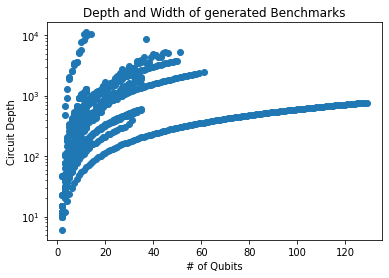

In [21]:
characteristics = np.array(characteristics)
plt.scatter(x=characteristics[:, 2].astype(int), y=characteristics[:, 1].astype(int))
plt.yscale("log")
plt.title("Depth and Width of generated Benchmarks")
plt.xlabel("# of Qubits")
plt.ylabel("Circuit Depth")
plt.savefig("test")

# Debugging

In [ ]:
import os

qasm_path = "./qasm_output"
i = 0
for filename in os.listdir(qasm_path):
    if "ae" in filename and filename.endswith(".qasm"):
        i += 1
        print(i)
        try:
            path = "qasm_output/" + filename
            qc = QuantumCircuit.from_qasm_file(path)
        except:
            # os.remove(path)
            print("removed: ", filename)

1
2
removed:  ae_mapped_rigetti-s_opt0_28.qasm
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
removed:  ae_mapped_rigetti-s_opt0_24.qasm
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
removed:  ae_mapped_rigetti-s_opt0_32.qasm
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
removed:  ae_mapped_rigetti-s_opt0_33.qasm
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
removed:  ae_mapped_rigetti-s_opt0_25.qasm
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
removed:  ae_mapped_rigetti-s_opt0_29.qasm
210
211
212
21

In [ ]:
from src.benchmarks import vqe

In [ ]:
vqe.create_circuit(19)